## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [28]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

In [29]:
# Random state seed
rseed = 42

## Load and explore data

In [30]:
# Import the dataset
df = pd.read_csv('Country-data.csv',index_col=0)

In [31]:
# Check the shape
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


The index column contains the country names. This is helpful because if these object variables were part of the main body of the dataframe, they would require encoding. But as they are in the index, they will not affect the processing data .

But the list will be useful later, for future reference when the processing has been completed.

A dataframe will therefore be created from the index column, & this dataframe will be re-joined to the dataset at the end.


In [32]:
# Defines the index column as the list of countries
country_list = df.index
country_list

Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       ...
       'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay',
       'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia'],
      dtype='object', name='country', length=167)

In [33]:
# Converts the list of countries into a dataframe
country_df = pd.DataFrame({'Country': country_list})
country_df.head()         #  Checks that the list of countries has actually been converted to a dataframe

,Country
0,Afghanistan
1,Albania
2,Algeria
3,Angola
4,Antigua and Barbuda


In [34]:
country_df.info    # Double-checks the size of the list of countries, (it must have 167 items) to ensure it will work with any future transformations 

<bound method DataFrame.info of                  Country
0            Afghanistan
1                Albania
2                Algeria
3                 Angola
4    Antigua and Barbuda
..                   ...
162              Vanuatu
163            Venezuela
164              Vietnam
165                Yemen
166               Zambia

[167 rows x 1 columns]>

ANSWER:
From the cell above, apart from the country index column, there appear to be no other non-numeric values, so encoding will not be required for preprocessing.


In [35]:
# Check datatypes & counts
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB


From the information above, the dataset contains integers or floats only, & there are no missing values.
Therefore, no columns need be dropped because of non-numeric, or object variables.

In [36]:
# Understand scope of the data
# Get descriptive statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


From the description above, the variable with the largest range is Income, & the variable with the smallest range is fertility. This indicates that Income may have some outliers that could skew the data, and affect the modelling.

In [37]:
# Identify any missing data
df.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


The cell above shows that there are no missing values.

In [38]:
# Identify any Nan values which may affect the classifiers used in later code
df.isna().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

The cells above show that there are no Nan values in the dataset, which could affect the classifier used. The isnull code above this, also shows that there are no missing.

Consequently, no more preprocessing is required to deal with missing or NaN values.

## Preprocessing and Feature Selection

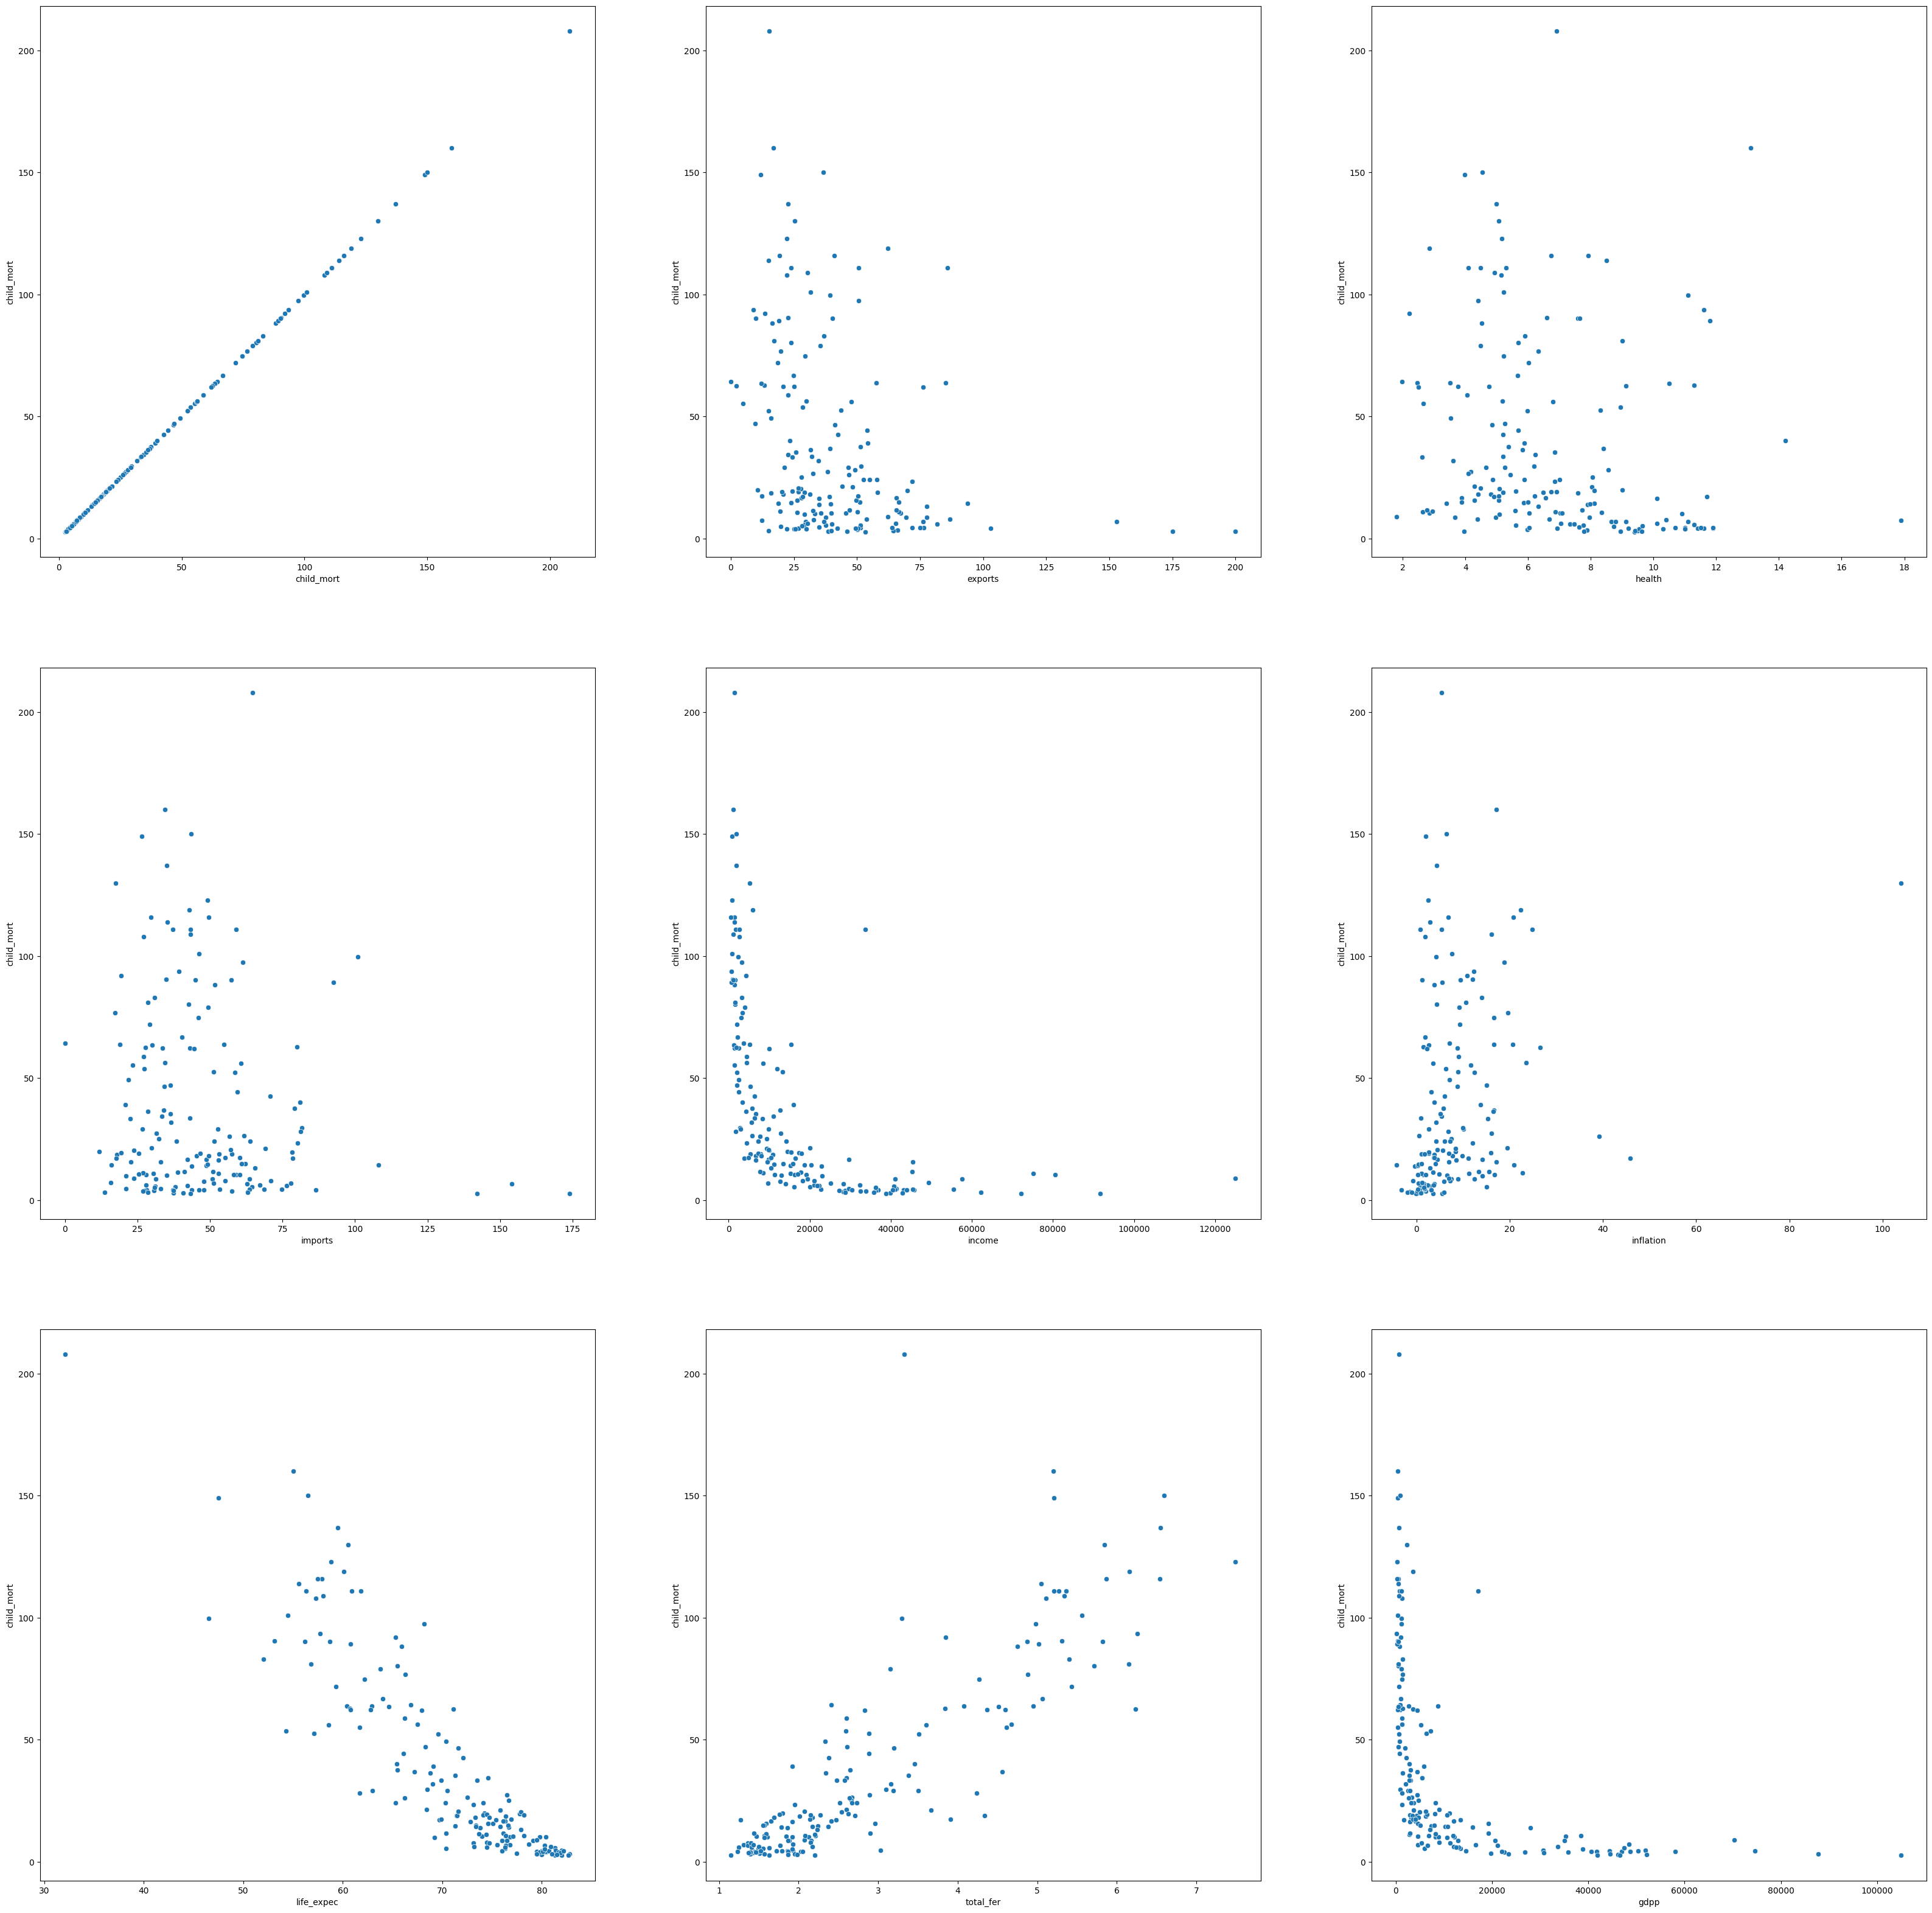

In [39]:
# Explore the continuous independent features against child_mort using scatter plots.
columns = df.columns.tolist()

fig, axes = plt.subplots(3, 3, figsize =(40,40))

axes = axes.flatten()

for i, var in enumerate(columns):
  sns.scatterplot(ax = axes[i], x = df[var], y = df['child_mort'])


ANSWER: 

Looking at these 9 scatterplots above, 3 features which appear to be clustering more than others are: Health, Exports, & Imports. 
Of those 3, exports appears to be the a promising feature for K Means Cluster modelling for 2 reasons: 

1) Because the data points seem to be spread over a wide area within the feature space; so 'b'(the distance between nearest clustewrs), in the silhouette score could be large

2) Because the exports data points also appear to be clustering in places; so 'a' (the distance between points within a cluster), in the silhouette score could be small

It is also notable that Income appears to correlate closely with gdpp, but these scatterplots do not clearly indicate bunching or clustering of data points.

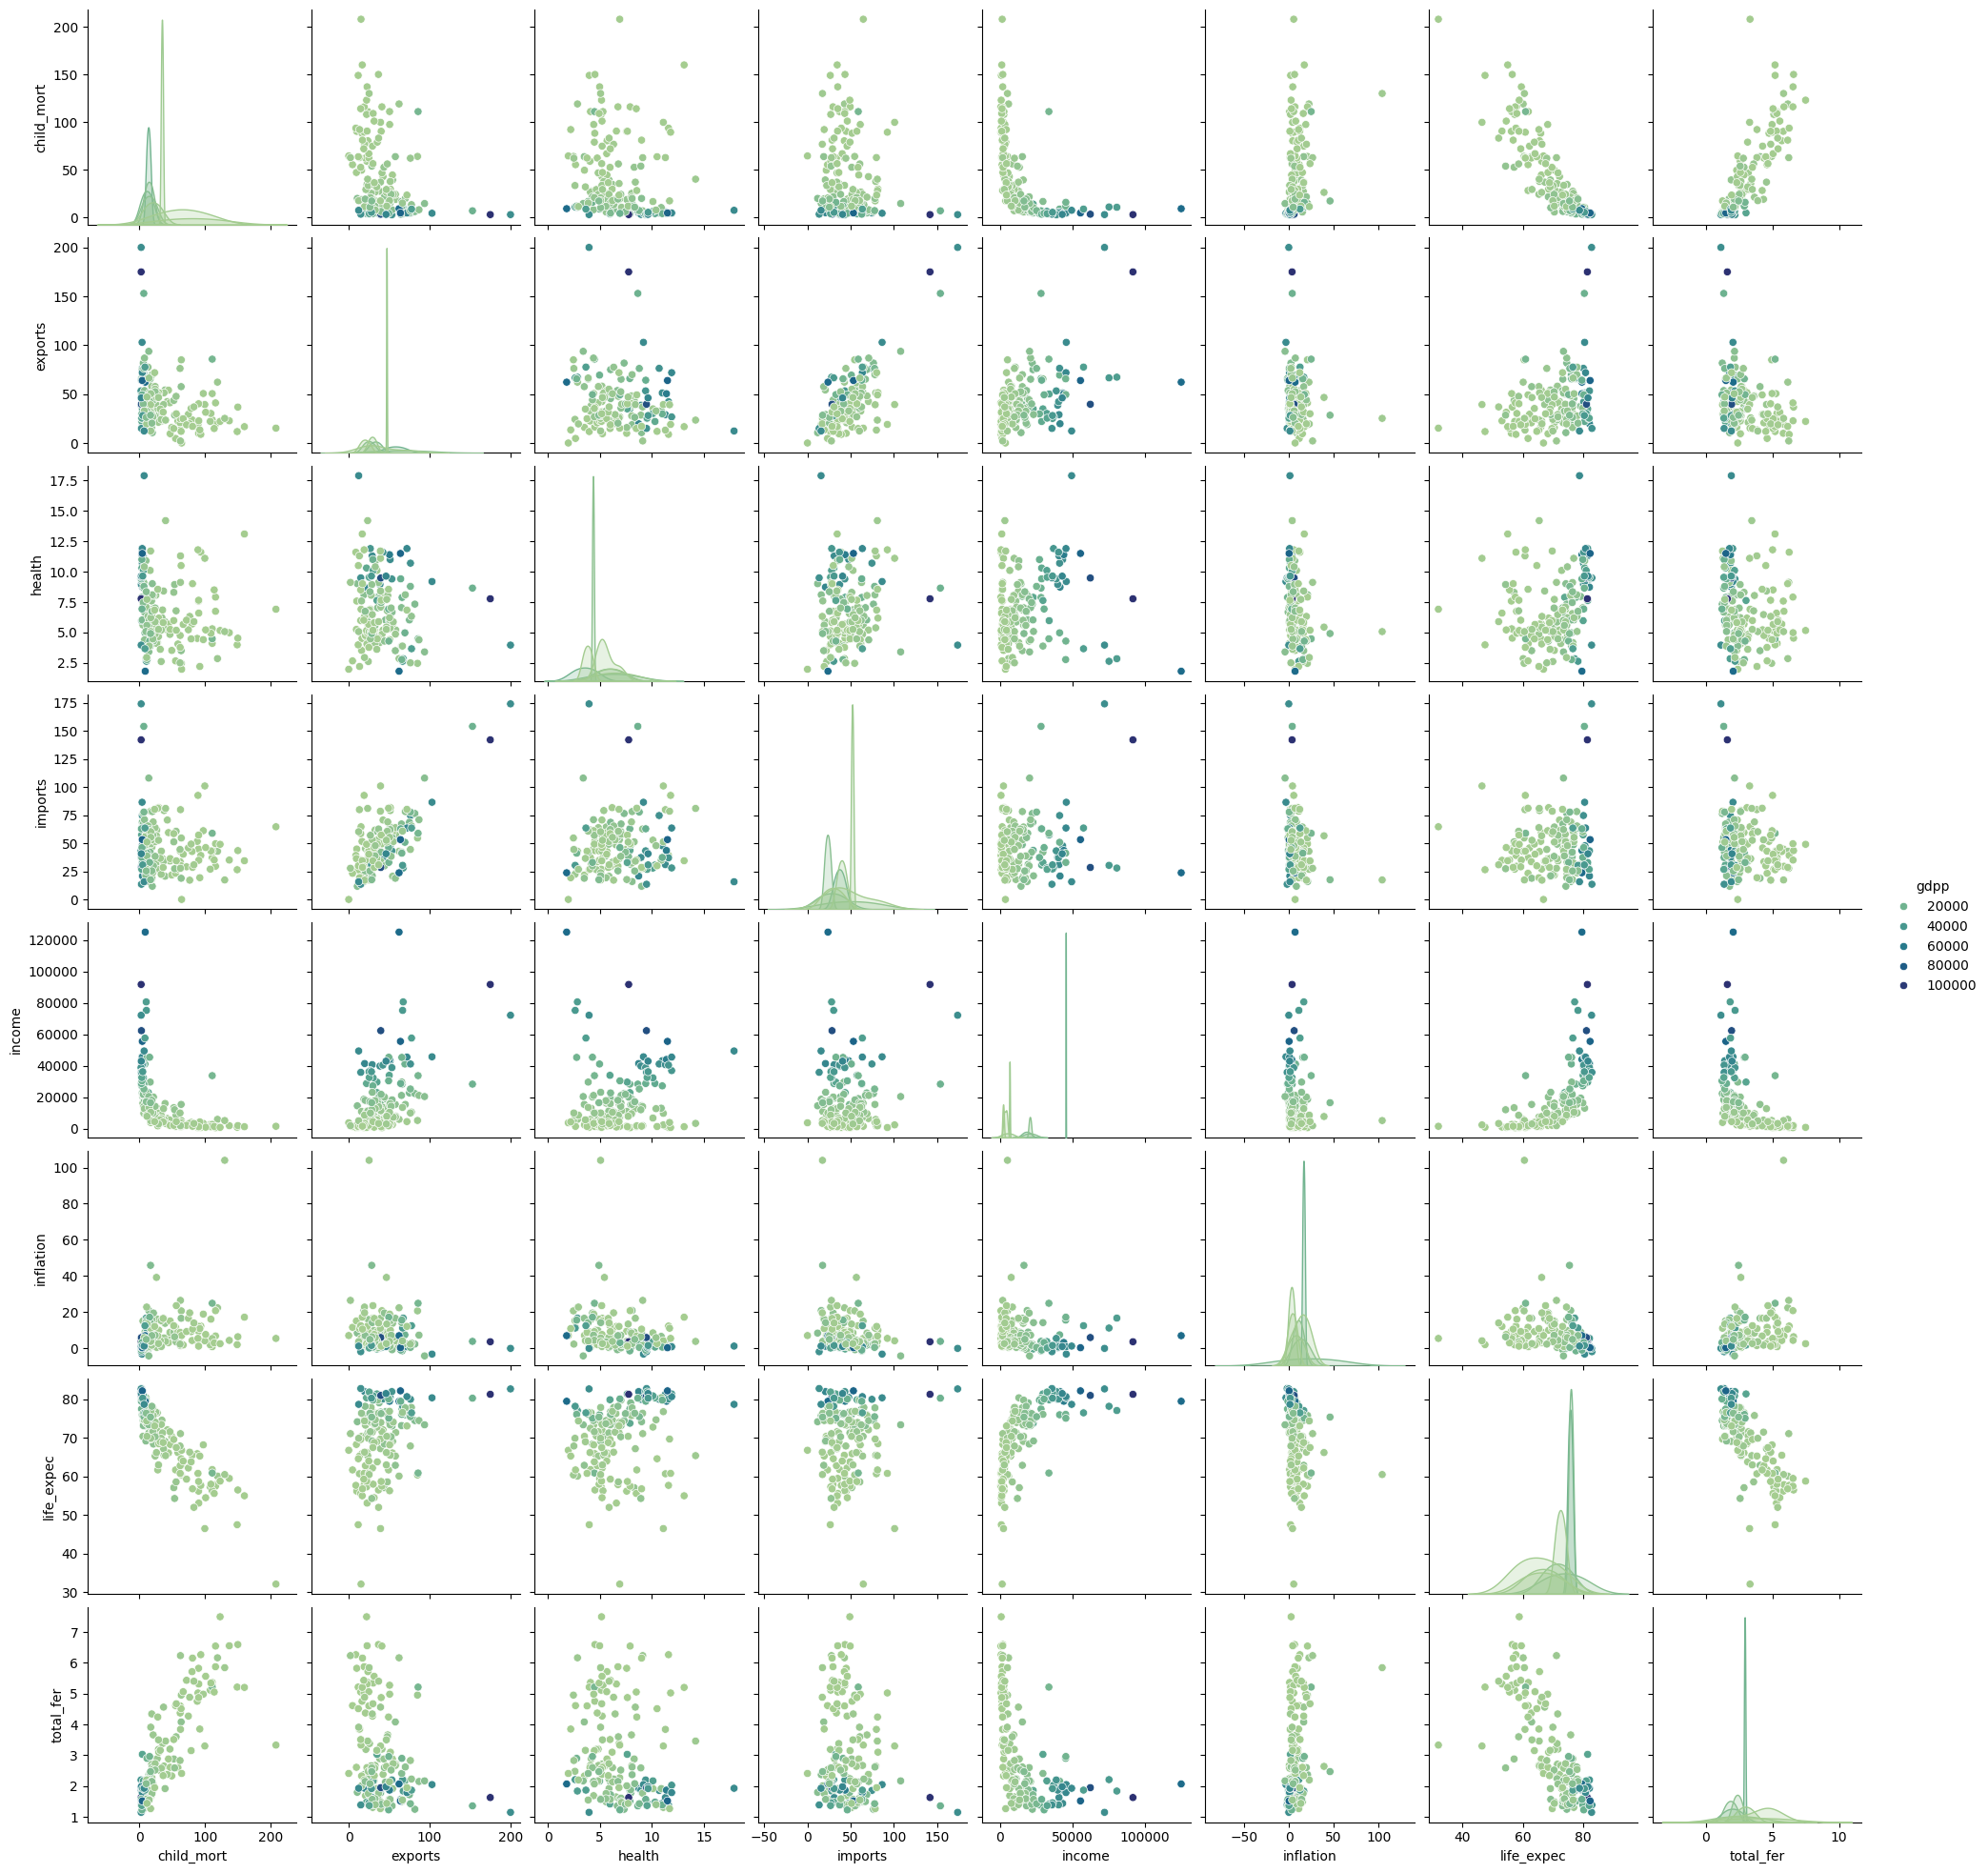

In [40]:
# To further explore the relationships between featuresr, pairplots are used
# Pairplot of all the features
sns.pairplot(df, hue= 'gdpp', palette= 'crest')

Looking at the leading diagonal in these pairplots, shows that Income would be a good feature to use for clustering. This is because the values in the chart show 4 distinct, non-overlapping peaks. Some of the other features also have clear peaks, but none of them are as distinct and separated as the Income variable.

Therefore Income may be the best feature to process for clustering.

ANSWER: MinMaxScaler

In [41]:
# To normalise the data using MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

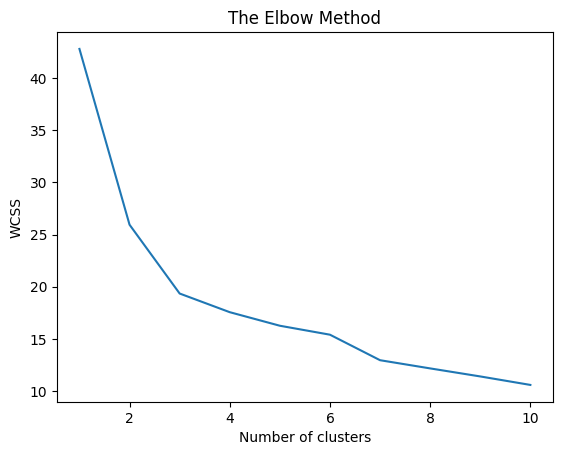

In [42]:
# elbow & silhouette score
# Deciding the number of clusters k; use elbow method
wcss = []

# For each n_clusters, i, get the inertia
for i in range(1, 11): # 1 to 10 clusters
        kmeans = KMeans(n_clusters = i, random_state = 42)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)

# visualisation
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The Elbow Method graph aboove indicates that the optimal number of clusters could be 3. This is because the 'elbow', or sharp change in gradient of the Within Cluster Sum of Squares line is at around 3 along the Number of Clusters line. This graph also indicates that, with K larger than 3, there is a risk of overfitting because the WCSS does not change significantly, but the data is being split into smaller and smaller clusters.

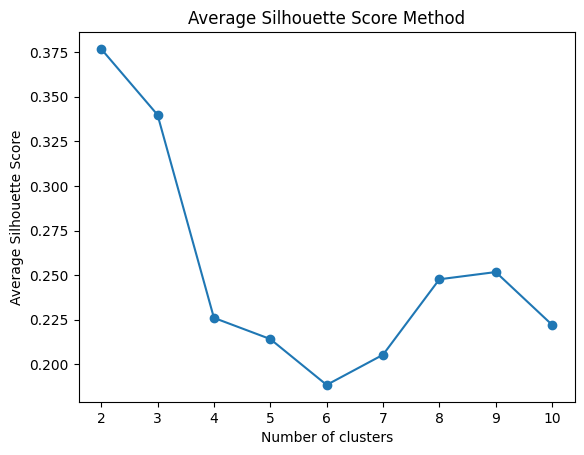

In [43]:
# Iterates over the average silhouette scores and stores them in a list to plot against the number of clusters
silhouette_scores = []

# For each n_clusters, i, get the avg silhouette
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(df)

    silhouette_avg = silhouette_score(df, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# visualisation
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score Method')
plt.show()

ANSWER: Optimal Clusters = 3

The Average Silhouette Score graph above also indicates that 3 clusters would be optimal in the fit. This is because the silhouette value (approx 0.33) drops significantly after 3 clusters. 
Noteably, the silhouette score rises again between 8 & 9 clusters, but this would risk over fitting, and yield a lower score (approx 0.25), than the score with 3 clusters.

In [44]:
# Fits the scaled dataset with the optimal K = 3
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(df)

KMeans(n_clusters=3, random_state=42)

In [45]:
# For the silhouette score with this model
labels = kmeans.labels_
score = silhouette_score(df, labels)

print("The Silhouette Score is: ", score)


The Silhouette Score is:  0.33976487765323604


ANSWER: KMeans classifier has been fit & the Silhouette Score is 0.340 to 3 decimal places. 

Silhouette Scores below 0.25 are not good. Silhouette Scores of 0.5 are good.

Therefore this model has performed reasonable well, but not optimally.

In [46]:
# Converting the dataset back into a dataframe, with the cluster catagory labelling each country
df = pd.DataFrame(df, columns = columns)

df['Cluster'] = labels       # Adds the Cluster column onto the dataframe as a label and catagory for each country
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,2
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,0
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,0
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,2
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,0


The sample of data above demonstrates that the dataset has been sorted into clusters, the first 5 samples catagorised in either cluster 0 or 2.

In [47]:
# Checks the values in the clustered and scaled sataset
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.173661,0.205112,0.311106,0.269207,0.132933,0.110820,0.758495,0.283591,0.121536,0.748503
std,0.196343,0.137135,0.170717,0.139188,0.154980,0.097687,0.175408,0.238777,0.174944,0.855306
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027507,0.118520,0.193288,0.173250,0.022076,0.055633,0.654832,0.101735,0.010490,0.000000
50%,0.081305,0.174550,0.280298,0.248566,0.075174,0.088716,0.808679,0.198738,0.042274,0.000000
75%,0.289679,0.256345,0.422001,0.337393,0.178397,0.138250,0.881657,0.430599,0.131900,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


And comparing the new description summary above, with the original summary in cell 178, also shows that the dataset has been successfully scaled.

ANSWER: Scatterplots visualising the clustered data

<Axes: xlabel='child_mort', ylabel='gdpp'>

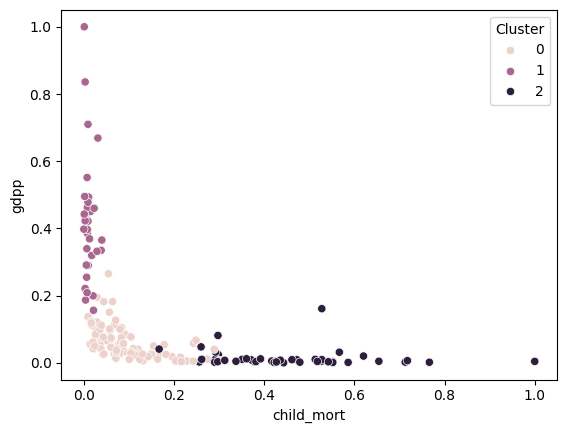

In [48]:
# Visualising a selection of features against GDPP
# Plot Child Mortality vs GDPP
sns.scatterplot(x = df['child_mort'], y = df['gdpp'], hue = df['Cluster'])
     

The Child Mortality scatterplot above shows that as child mortality increases, gdpp decreases exponentially. Cluster 1, have very low Child Mortality, & the range of Child Mortalities for Cluster 1 is very narrow.

Conversely, Cluster 2 have the highest values for Child Mortality, & the range of Child Mortalities is wide. Cluster 0 range from low Child Mortality rates, to higher ones.

On the whole, Child Mortality appears to be a good feature to cluster, in order to classify the countries in this datset, because the scatterplot has distinct feature spaces for each cluster

<Axes: xlabel='inflation', ylabel='gdpp'>

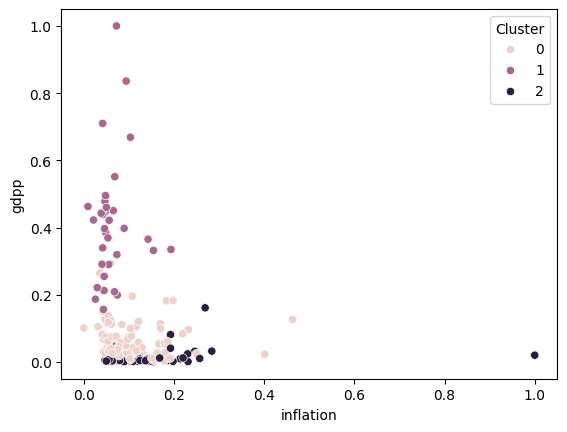

In [49]:
# Plot Inflation vs GDPP
sns.scatterplot(x = df['inflation'], y = df['gdpp'], hue = df['Cluster'])

The Inflation scatterplot above shows that Inflation rates tend to overlap all 3 clustewrs. For example 0.1 on the Inflation axes captures countries in all 3 clusters. 

On the whole, it appears that Inflation is not the best feature to use to classify the dataset. This is because the clusters tend to overlap in each other's feature space.

<Axes: xlabel='income', ylabel='gdpp'>

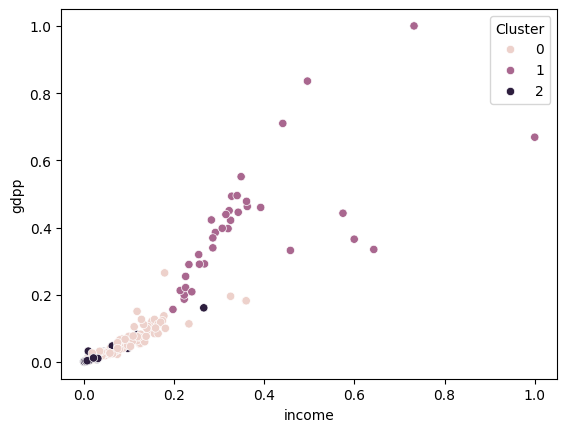

In [50]:
# Plot Income vs GDPP
sns.scatterplot(x = df['income'], y = df['gdpp'], hue = df['Cluster'])

This additional Income scatterplot has been visualised to test the conclusuin drawn from the pairplot diagonals in cell 476 above. The pairplots indicated that Income would be a good feature to use for clustering.

The graph above tends to corroberate this because the clusters appear to occupy 3 sewparate regions in the feature space.

In [51]:
# Calculates the mean values for the features in each cluster group
df.groupby('Cluster').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Cluster,,,,,,,,,
0,0.096839,0.201990,0.275476,0.271713,0.096755,0.109138,0.796005,0.183854,0.061339
1,0.011184,0.291771,0.441730,0.295760,0.363321,0.062333,0.949620,0.093240,0.409340
2,0.448556,0.143746,0.278392,0.243711,0.023687,0.151784,0.537322,0.624465,0.014068


ANSWER: Labelling the clusters

The mean values above help to explain what each cluster label represents in terms of the standard of living for each labelled country.
On inspection, it is clear that the mean Child Mortality rate is 40 times higher in Cluster 2, than it is in Cluster 1. This indicates that the survival conditions for babies born in Cluster 2 countries, are leading to more deaths than the conditions for Cluster 1. 
This mean values table also shows that mean incomes for Cluster 2 countries are 18 times lower than the mean incomes for Cluster 1 countries. 

From these 2 feature comparisons, as well as the life expectancy averages, the following conclusions may be drawn:

Cluster 2: represents compariitively lower outcomes
Cluster 1: represents comparitively higher outcomes
Cluster 0: represnts comparitively mid-range outcomes

Consequently, these 3 catagories will designated as follows:

Cluster 1: Post Industrial Countries (Post Industrial)

Cluster 0: Mid Industrial Countries  (Mid Industrial)

Cluster 2: Pre Industrial Countries  (Pre Industrial)

In [52]:
# Catagorising the standard of living based on this analysis
# Label the groups of countries and rename column
df['Cluster'] = df['Cluster'].map({0: 'Mid Industrial', 1: 'Post Industrial', 2: 'Pre Industrial'})
df = df.rename(columns ={'Cluster':'Industrialisation'})
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Industrialisation
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,Pre Industrial
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,Mid Industrial
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,Mid Industrial
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,Pre Industrial
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,Mid Industrial


The clusters have now been given a more informative label, relating directly to the comparitive standard of living there.

In [53]:
# To re-insert the country names so that the dataset is easier to interpret
# The contries were listed in the index in the original dataframe.
# The list was converted to a unique dataframe at the start of this notebook.
# Joins 2 dataframes together; the first dataframe contained the list of countries in the index of the original datframe in cell
df = pd.concat([country_df, df], axis = 1, join= 'inner')
df.head()

,Country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Industrialisation
0,Afghanistan,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,Pre Industrial
1,Albania,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,Mid Industrial
2,Algeria,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,Mid Industrial
3,Angola,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,Pre Industrial
4,Antigua and Barbuda,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,Mid Industrial


The 2 dataframes have joined together, & it is now easy to identify the actual countries that have been labelled.

In [54]:
df.sample(30)    # Checks a random sample of data to see if the labels are intuitively or experiencially correct

,Country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Industrialisation
122,Portugal,0.006329,0.149036,0.571162,0.214645,0.213769,0.044848,0.940828,0.037855,0.212553,Post Industrial
20,Bosnia and Herzegovina,0.020935,0.148036,0.577377,0.294560,0.073245,0.051844,0.881657,0.025237,0.041797,Mid Industrial
22,Brazil,0.083739,0.052984,0.447483,0.067463,0.111672,0.116625,0.830375,0.102524,0.104697,Mid Industrial
8,Austria,0.008277,0.256095,0.571162,0.274438,0.342396,0.046973,0.954635,0.045741,0.445447,Post Industrial
0,Afghanistan,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,Pre Industrial
49,Equatorial Guinea,0.527751,0.428689,0.165942,0.338255,0.266024,0.269014,0.568047,0.640379,0.161011,Pre Industrial
45,Dominican Republic,0.154820,0.113017,0.274083,0.191073,0.084339,0.089178,0.838264,0.228707,0.049814,Mid Industrial
41,Croatia,0.014119,0.187557,0.369795,0.218670,0.156691,0.046493,0.871795,0.063091,0.126650,Mid Industrial
18,Bhutan,0.195229,0.212071,0.210690,0.406097,0.046716,0.094261,0.788955,0.194006,0.018603,Mid Industrial
141,St. Vincent and the Grenadines,0.088121,0.134028,0.165320,0.327906,0.074853,0.079937,0.779093,0.145110,0.057259,Mid Industrial


The final analysis, from the table above, indicates that this clustering process has labelled the countries appropriately on the whole. 

For example, in the sample above of 30 randomly selected entries, 7 of the nations are labelled with as PostIndustrial. Looking at those 7 countries, which include United Kingdom, Netherlands, United Arab Emirates, Germany, Denmark, & Sweden, they are indeed correctly identified as post industrial. Similarly, the 7 countries labelled PreIndustrial in the random sample above are: Chad, Madagascar, Eritrea, Haiti, Malawi, Tanzania, & Comoros. And for the same reasons, it can be inferred that this labelling is appropriate. The mid industrial nations also appear to be correctly labelled.

So it therefore appears that all three groups of countries have been correctly classified through the K-Means Clustering process. 